<a href="https://colab.research.google.com/github/Epistimonas/imagenes/blob/master/Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, GRU

import os
import numpy as np
import matplotlib.pylab as plt

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

#Dataset

In [17]:
dataset, info = tfds.load('definite_pronoun_resolution/plain_text', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
info

Shuffling and writing examples to /root/tensorflow_datasets/definite_pronoun_resolution/plain_text/1.0.0.incompleteZG3RU7/definite_pronoun_resolution-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/definite_pronoun_resolution/plain_text/1.0.0.incompleteZG3RU7/definite_pronoun_resolution-train.tfrecord


Dataset definite_pronoun_resolution downloaded and prepared to /root/tensorflow_datasets/definite_pronoun_resolution/plain_text/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='definite_pronoun_resolution',
    version=1.0.0,
    description='Composed by 30 students from one of the author's undergraduate classes. These
sentence pairs cover topics ranging from real events (e.g., Iran's plan to
attack the Saudi ambassador to the U.S.) to events/characters in movies (e.g.,
Batman) and purely imaginary situations, largely reflecting the pop culture as
perceived by the American kids born in the early 90s. Each annotated example
spans four lines: the first line contains the sentence, the second line contains
the target pronoun, the third line contains the two candidate antecedents, and
the fourth line contains the correct antecedent. If the target pronoun appears
more than once in the sentence, its first occurrence is the one to be resolved.
',
    homepage='http://www.hlt.utdallas.edu/~vince/data/emnlp12/',
    features=FeaturesDict({
        'candidates': Sequence(Text(shape=(), dtype=tf.string)),
        'label': ClassLabel(shape

In [25]:
encoder = info.features['pronoun'].encoder
print ('Vocabulary size: {}'.format(encoder))

Vocabulary size: None


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

In [28]:
train_shape = tuple(map(lambda x:x.shape,train_dataset.element_spec))
test_shape = tuple(map(lambda x:x.shape,test_dataset.element_spec))
train_shape, test_shape

((TensorShape([]), TensorShape([])), (TensorShape([]), TensorShape([])))

In [29]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_shape)
test_dataset = test_dataset.padded_batch(BATCH_SIZE,test_shape)

train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

#Model

In [0]:
EPOCHS = 5
STEPS_PER_EPOCH = 32
VALIDATION_STEPS = 16

In [0]:
def train(model, epochs=EPOCHS):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model.fit(train_dataset, epochs=epochs,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=test_dataset,
                      validation_steps=VALIDATION_STEPS
                      )

In [0]:
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1.0])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Cross Entropy')
  plt.ylim([0.0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

##Bidirectional LSTM

In [33]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

model.summary()

AttributeError: ignored

Train for 32 steps, validate for 16 steps
Epoch 1/5
32/32 [==============================] - 145s 5s/step - loss: 0.6923 - accuracy: 0.5381 - val_loss: 0.6895 - val_accuracy: 0.5918
Epoch 2/5
32/32 [==============================] - 149s 5s/step - loss: 0.6639 - accuracy: 0.6265 - val_loss: 0.6200 - val_accuracy: 0.7100
Epoch 3/5
32/32 [==============================] - 137s 4s/step - loss: 0.5553 - accuracy: 0.7471 - val_loss: 0.5447 - val_accuracy: 0.7490
Epoch 4/5
32/32 [==============================] - 149s 5s/step - loss: 0.5057 - accuracy: 0.7886 - val_loss: 0.4966 - val_accuracy: 0.7959
Epoch 5/5
32/32 [==============================] - 153s 5s/step - loss: 0.4581 - accuracy: 0.8032 - val_loss: 0.4749 - val_accuracy: 0.7979


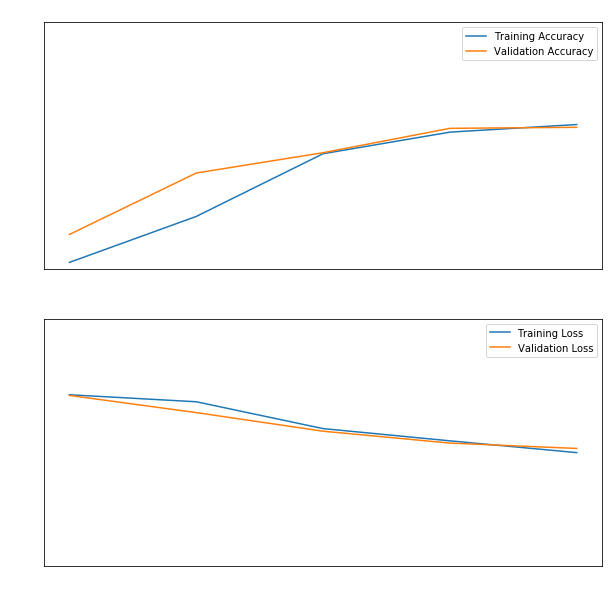

In [0]:
history = train(model)
plot_accuracy_and_loss(history)

##Stack LSTM

In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          261920    
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 352,865
Trainable params: 352,865
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = train(model)
plot_accuracy_and_loss(history)

Train for 32 steps, validate for 16 steps
Epoch 1/5
32/32 [==============================] - 259s 8s/step - loss: 0.6924 - accuracy: 0.5273 - val_loss: 0.6881 - val_accuracy: 0.5811
Epoch 2/5
32/32 [==============================] - 229s 7s/step - loss: 0.6229 - accuracy: 0.6621 - val_loss: 0.5586 - val_accuracy: 0.7178
Epoch 3/5
11/32 [=========>....................] - ETA: 2:08 - loss: 0.4834 - accuracy: 0.7685

##ConvNet

In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Conv1D(32, 3, padding='same', activation = 'relu'),
    MaxPooling1D(2),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

In [0]:
history = train(model, epochs=10)
plot_accuracy_and_loss(history)

##GRU

In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    GRU(64),
    Dense(1, activation='sigmoid')
])

model.summary()

history = train(model)
plot_accuracy_and_loss(history)

In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Conv1D(32, 3, padding='same', activation = 'relu'),
    MaxPooling1D(2),
    Bidirectional(GRU(64)),
    Dense(1, activation='sigmoid')
])

model.summary()

history = train(model, epochs=10)
plot_accuracy_and_loss(history)

